In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'FR.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,65,-35,30,6,39,12,29,102,0,...,868,21,0,33,83,23,286,19,-26,117.4
1,2014-06-30,67,-43,24,8,65,8,24,118,0,...,891,16,0,36,72,49,298,27,-27,117.4
2,2014-09-30,41,-32,9,-11,33,7,33,88,0,...,875,21,0,38,76,42,291,5,-26,117.4
3,2014-12-31,73,-45,28,-65,40,5,18,75,0,...,771,26,0,38,78,30,251,42,-26,117.4
4,2015-03-31,55,-32,22,-1,22,8,17,62,0,...,757,21,0,39,75,21,236,6,-12,129.1


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,263.1,148,-161,-13,-17,151,9,65,...,0,2110,41,0,14,167,210,699,-15,-55
36,2023-03-31,2023-04-21,277.2,157,-158,-1,-101,105,7,71,...,0,1984,34,0,17,141,212,653,-5,-49
37,2023-06-30,2023-07-21,277.2,147,-137,9,-18,160,5,58,...,0,2014,36,0,17,126,214,638,20,-37
38,2023-09-30,2023-10-21,277.2,133,-120,13,-27,138,9,61,...,0,1952,22,0,17,100,217,613,20,-34
39,2023-12-31,2024-02-11,277.2,137,-119,18,10,126,10,64,...,0,1976,32,0,18,120,219,618,25,-26


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,263.1,148,-161,-13,-17,151,9,65,...,2110,41,0,14,167,210,699,-15,-55,1.357405
36,2023-03-31,2023-04-21,277.2,157,-158,-1,-101,105,7,71,...,1984,34,0,17,141,212,653,-5,-49,1.352063
37,2023-06-30,2023-07-21,277.2,147,-137,9,-18,160,5,58,...,2014,36,0,17,126,214,638,20,-37,1.343352
38,2023-09-30,2023-10-21,277.2,133,-120,13,-27,138,9,61,...,1952,22,0,17,100,217,613,20,-34,1.341033
39,2023-12-31,2024-02-11,277.2,137,-119,18,10,126,10,64,...,1976,32,0,18,120,219,618,25,-26,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,263.1,200.895953,-218.542219,-17.646266,-23.075886,204.968168,12.216646,88.231331,...,2864.124729,55.653608,0.0,19.003671,226.686649,285.055068,948.826154,-20.361076,-74.657280,1.357405
36,2023-03-31,2023-04-21,277.2,212.273837,-213.625900,-1.352063,-136.558328,141.966579,9.464439,95.996449,...,2682.492309,45.970130,0.0,22.985065,190.640834,286.637283,882.896914,-6.760313,-66.251070,1.352063
37,2023-06-30,2023-07-21,277.2,197.472703,-184.039186,12.090166,-24.180331,214.936276,6.716759,77.914400,...,2705.510371,48.360662,0.0,22.836979,169.262317,287.477269,857.058400,26.867034,-49.704014,1.343352
38,2023-09-30,2023-10-21,277.2,178.357379,-160.923951,17.433428,-36.207889,185.062543,12.069296,81.803008,...,2617.696266,29.502724,0.0,22.797560,134.103292,291.004144,822.053182,26.820658,-45.595119,1.341033
39,2023-12-31,2024-02-11,277.2,186.541582,-162.032469,24.509113,13.616174,171.563791,13.616174,87.143513,...,2690.555961,43.571756,0.0,24.509113,163.394087,298.194208,841.479546,34.040435,-35.402052,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,10.473070,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,0.670507,0.329493,21.666667,6.666667,6.666667,4.827586,0.461538,0.092308,0.02765,0.041237
1,2014-04-28,10.671423,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,0.670507,0.329493,21.666667,6.666667,6.666667,4.827586,0.461538,0.092308,0.02765,0.041237
2,2014-05-05,10.066443,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,0.670507,0.329493,21.666667,6.666667,6.666667,4.827586,0.461538,0.092308,0.02765,0.041237
3,2014-05-12,9.788750,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,0.670507,0.329493,21.666667,6.666667,6.666667,4.827586,0.461538,0.092308,0.02765,0.041237
4,2014-05-19,9.768913,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,0.670507,0.329493,21.666667,6.666667,6.666667,4.827586,0.461538,0.092308,0.02765,0.041237


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,10.473070,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,4.827586,0.461538,0.092308,0.02765,0.041237,46.506454,1.917792,4.292903,5.242903,6.200860
1,2014-04-28,10.671423,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,4.827586,0.461538,0.092308,0.02765,0.041237,47.387254,1.954114,4.374208,5.324208,6.318301
2,2014-05-05,10.066443,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,4.827586,0.461538,0.092308,0.02765,0.041237,44.700797,1.843332,4.126227,5.076227,5.960106
3,2014-05-12,9.788750,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,4.827586,0.461538,0.092308,0.02765,0.041237,43.467677,1.792482,4.012401,4.962401,5.795690
4,2014-05-19,9.768913,2014-03-31,71.602964,0.225196,5.461004,117.4,198.285131,1.68897,42.961778,...,4.827586,0.461538,0.092308,0.02765,0.041237,43.379592,1.788849,4.004270,4.954270,5.783946


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

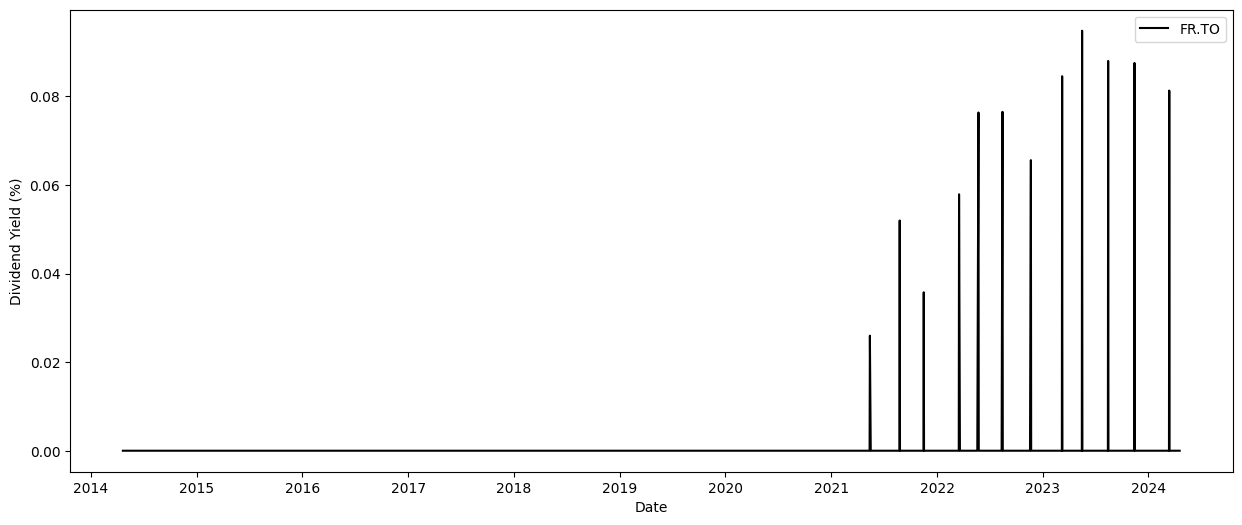

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.110271
share_price      1.000000
Name: share_price, dtype: float64


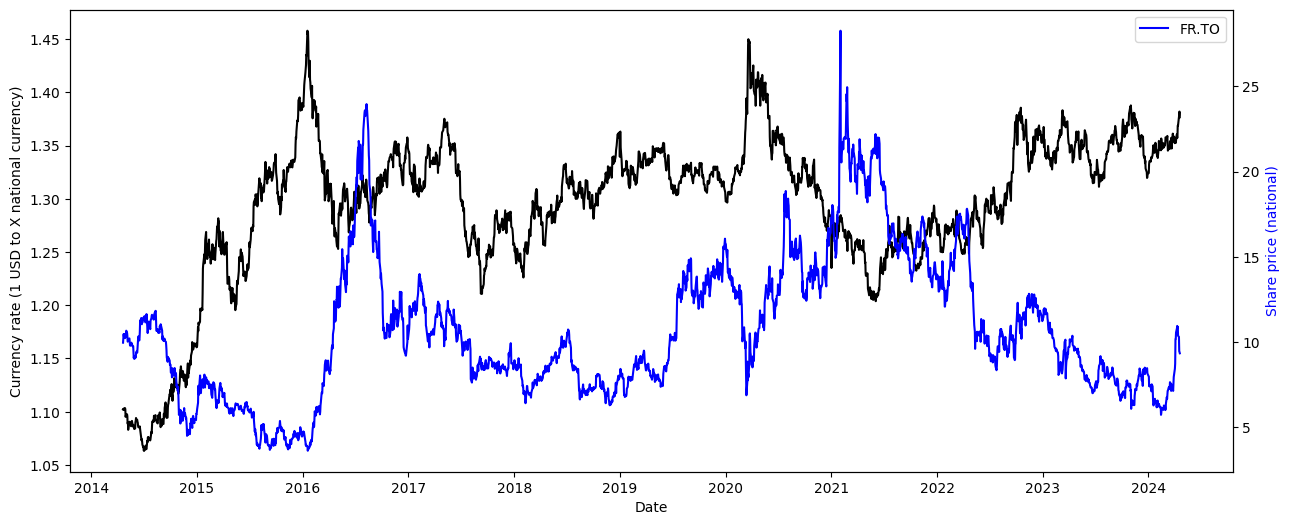

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

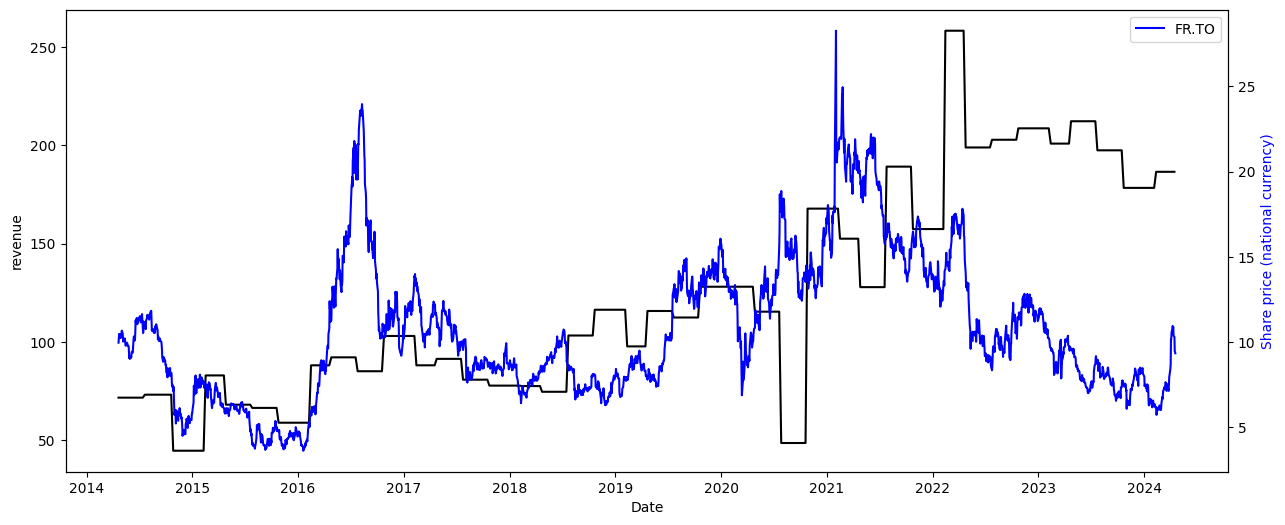

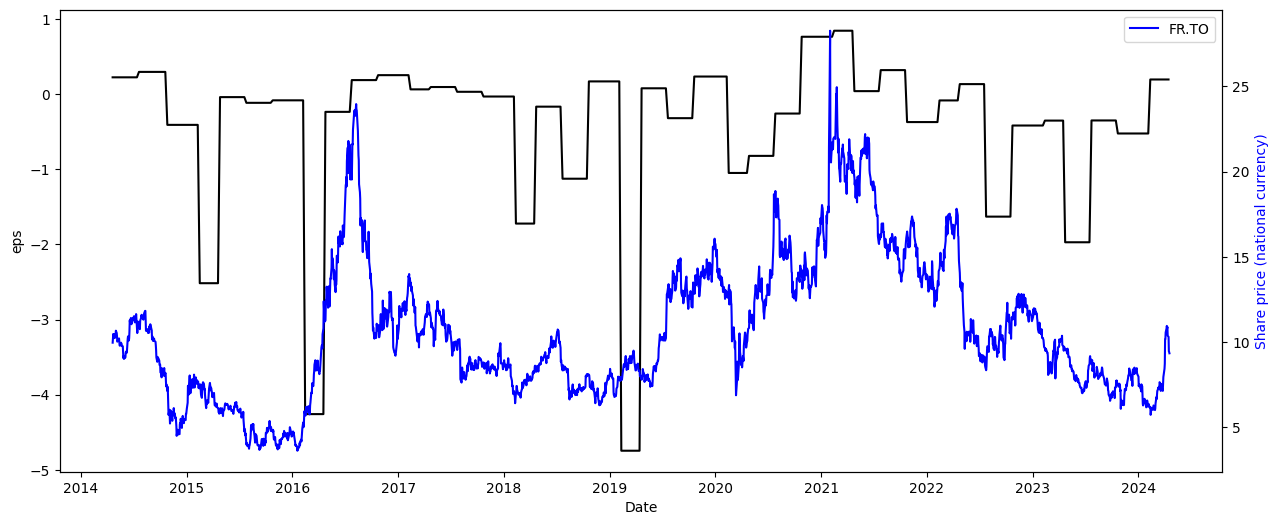

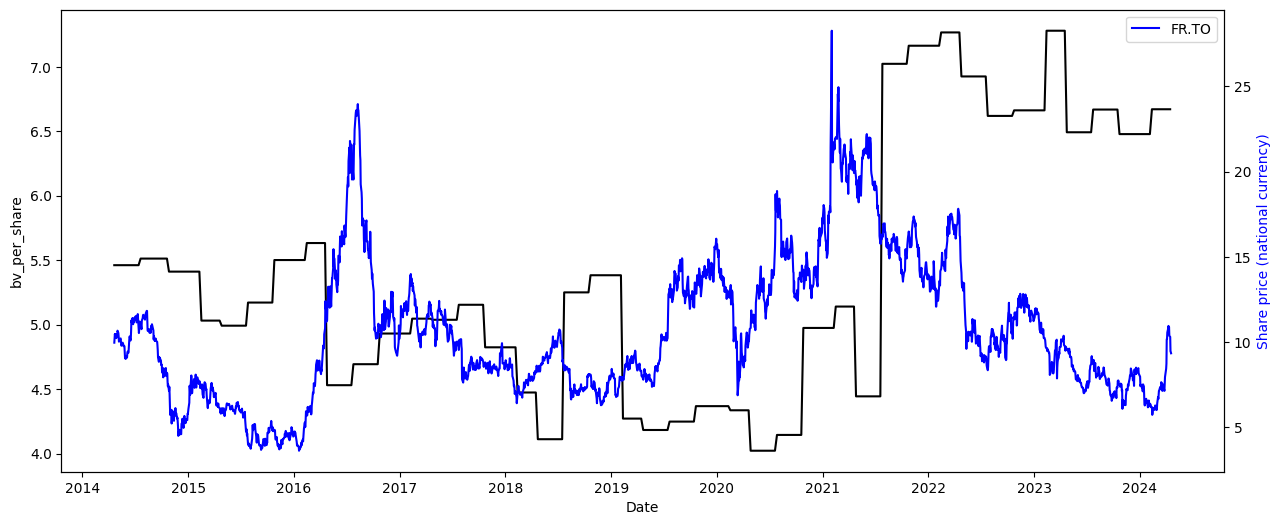

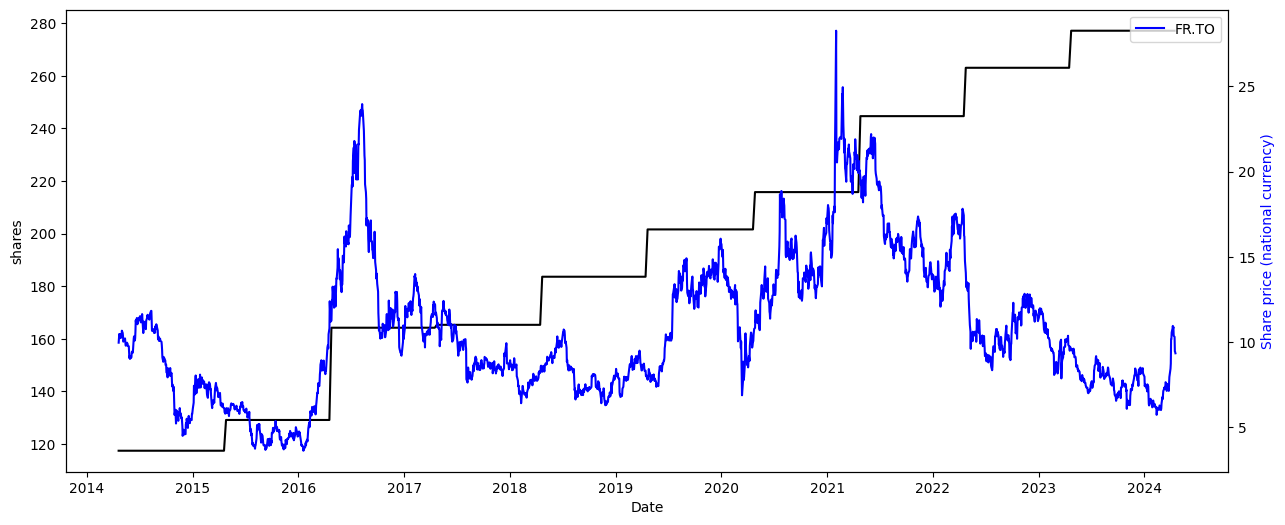

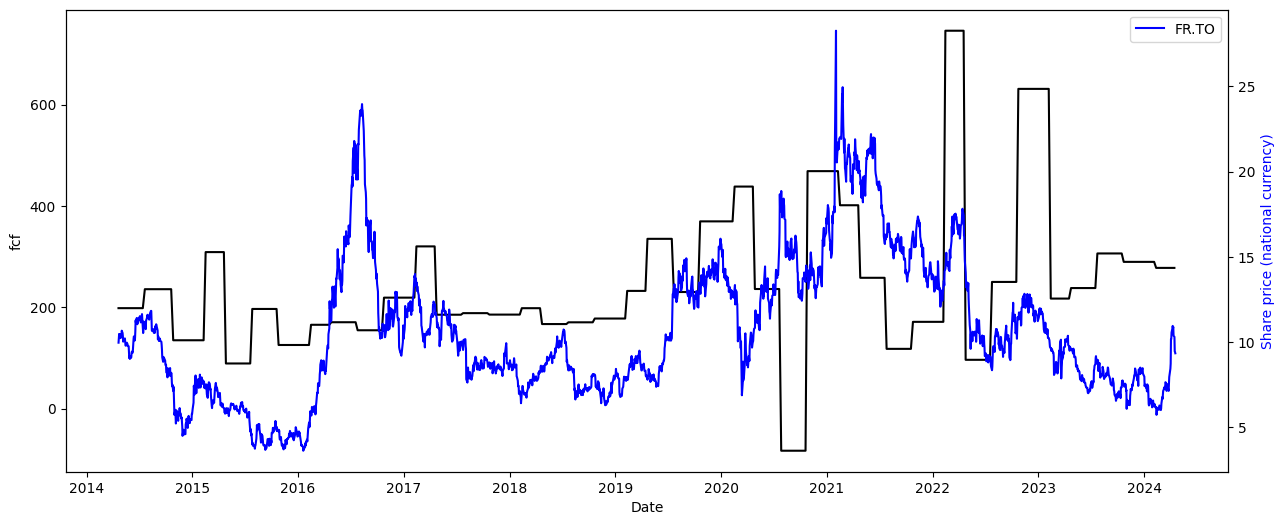

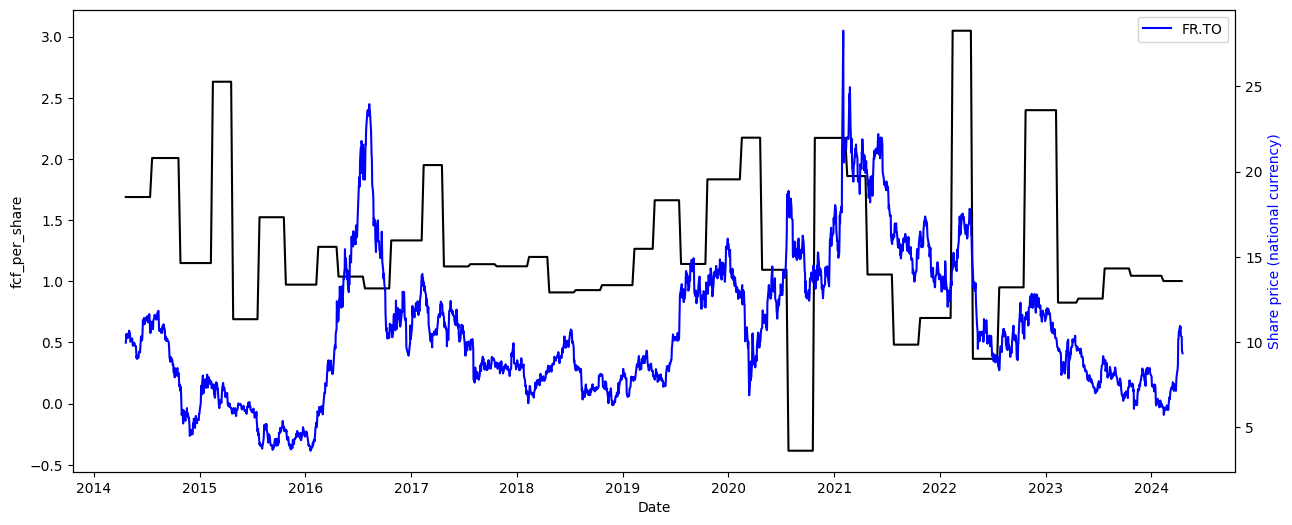

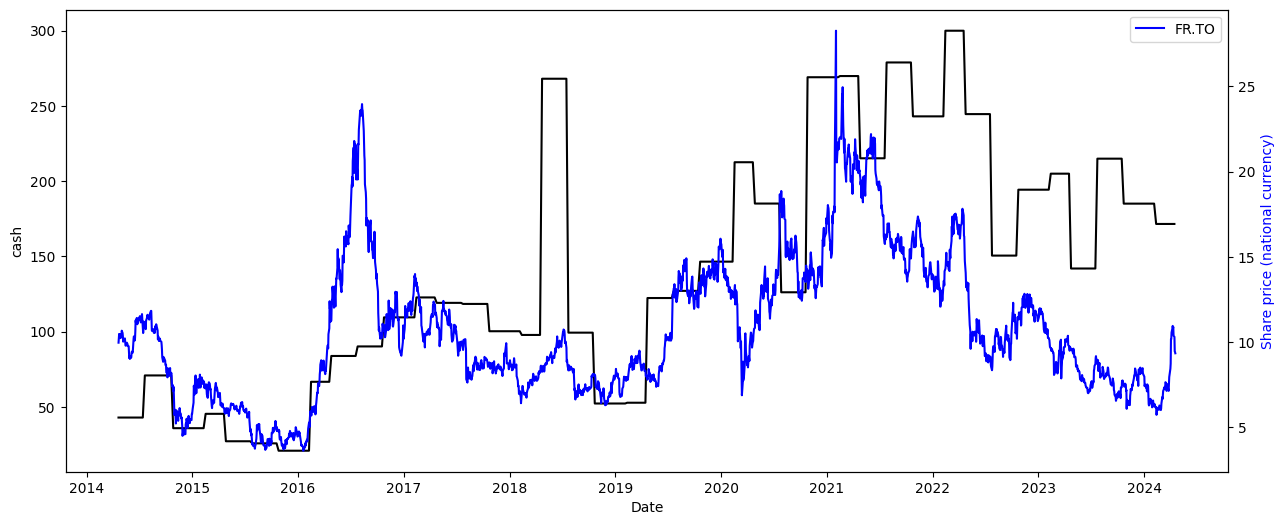

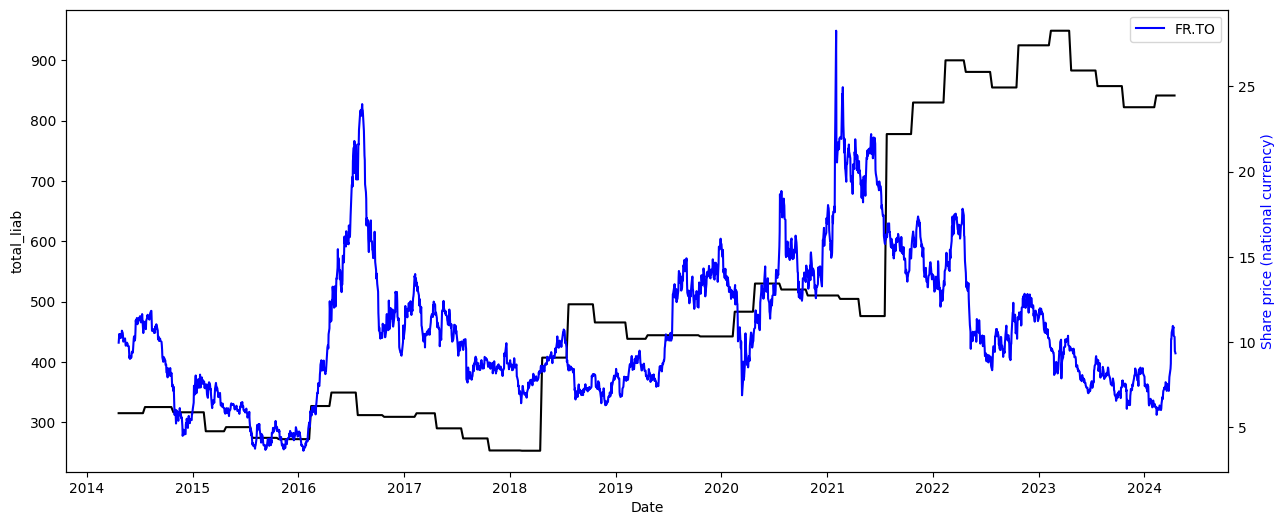

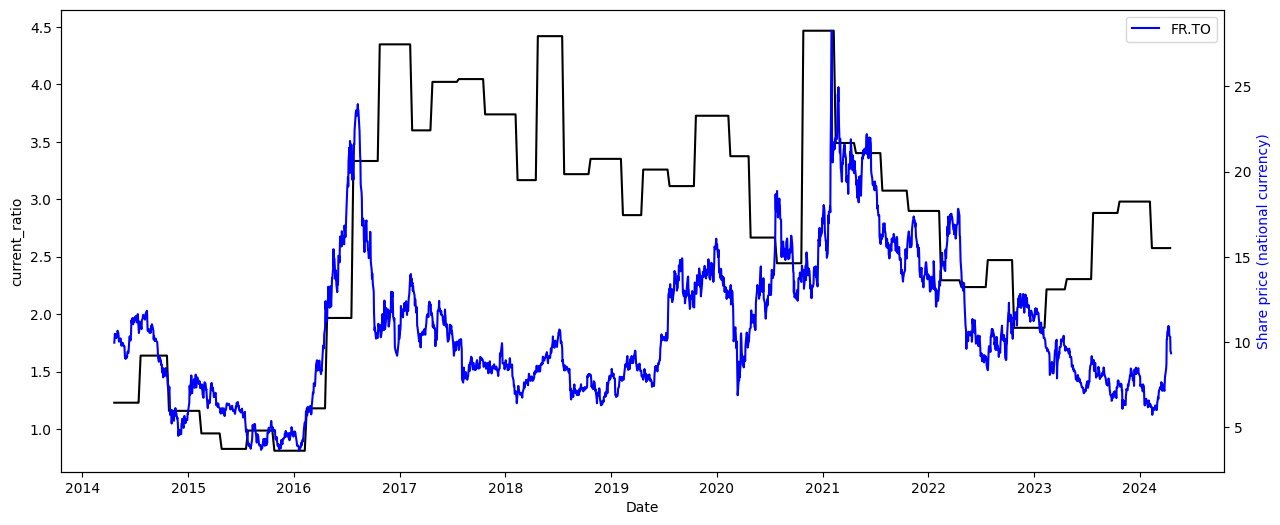

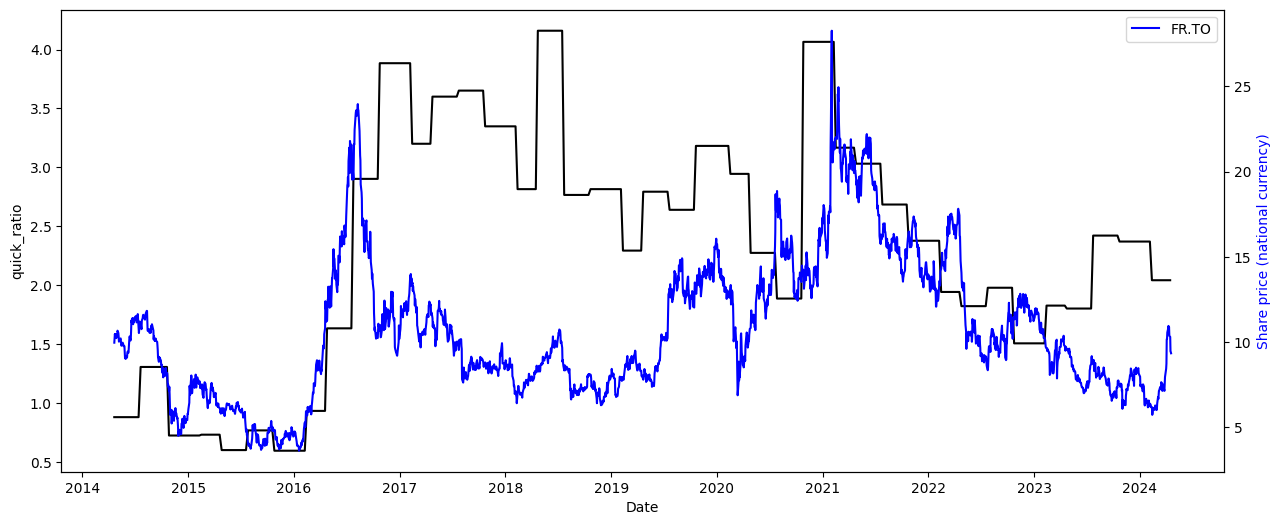

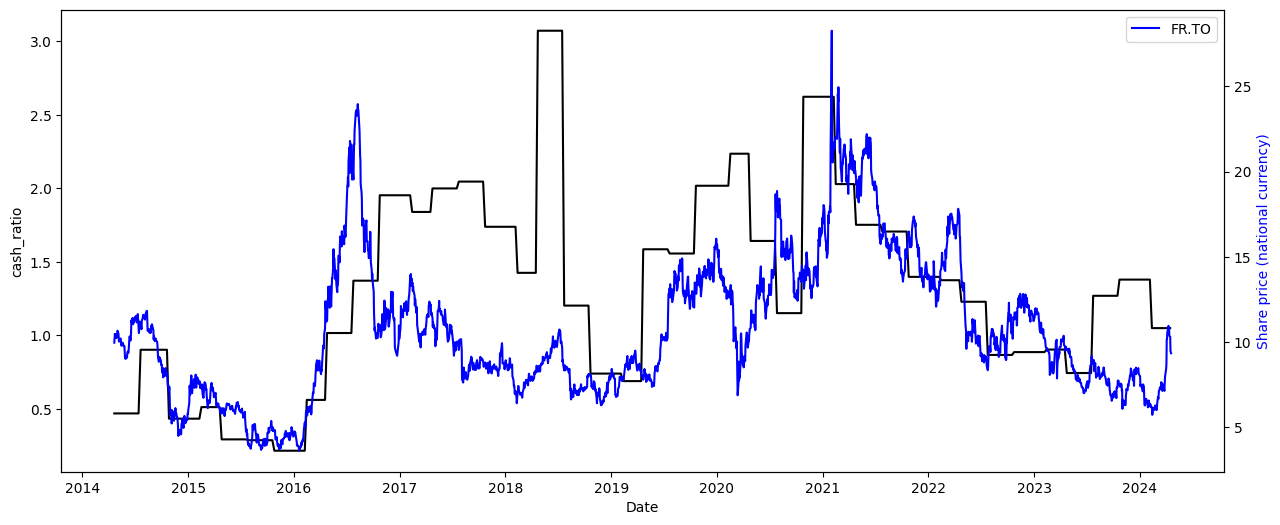

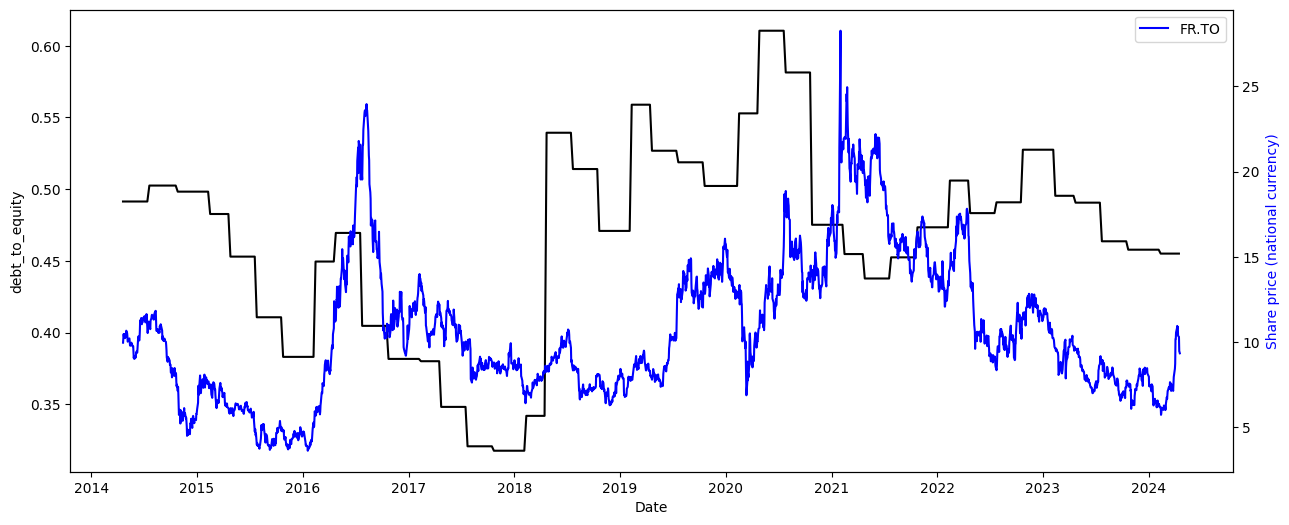

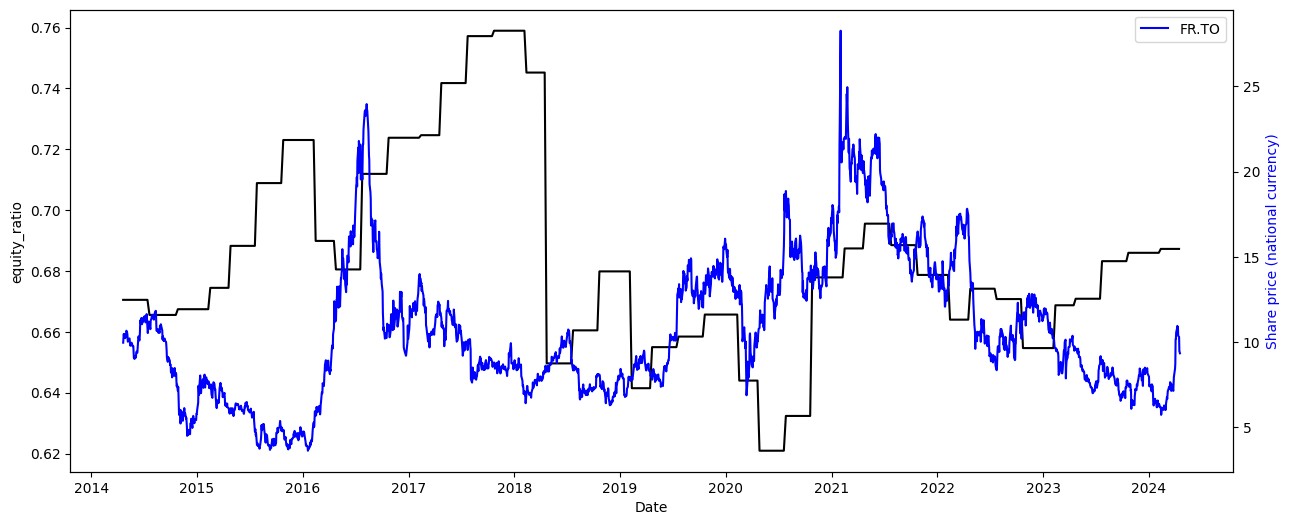

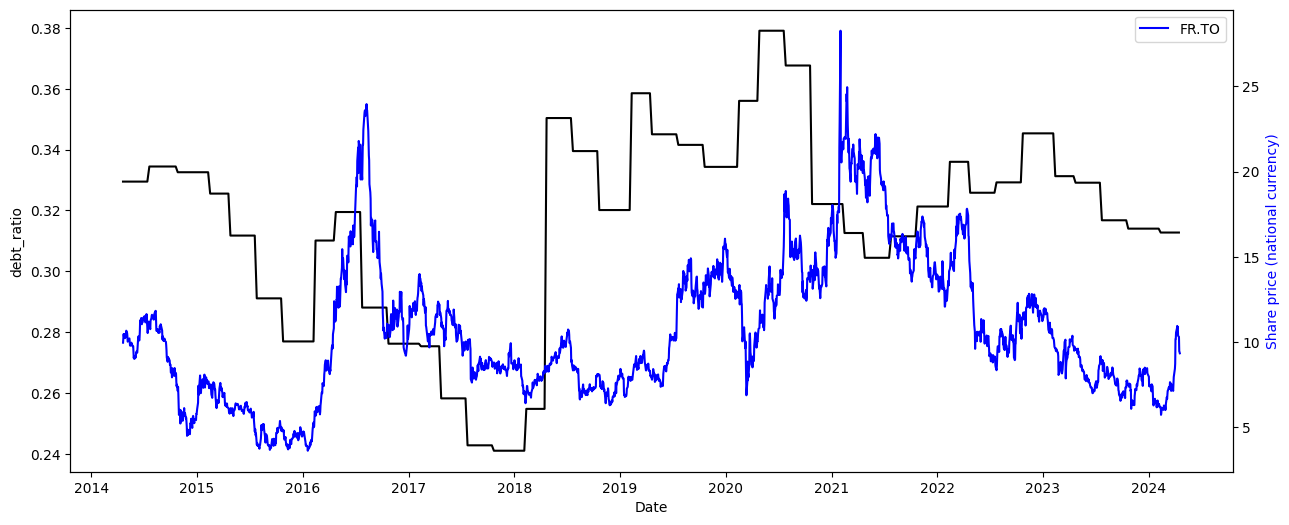

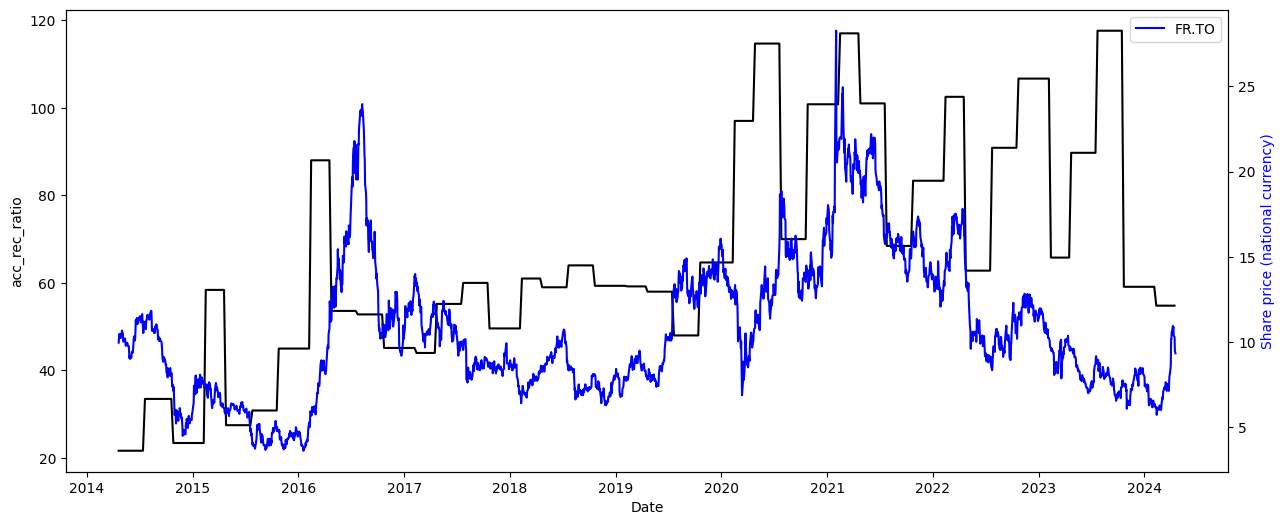

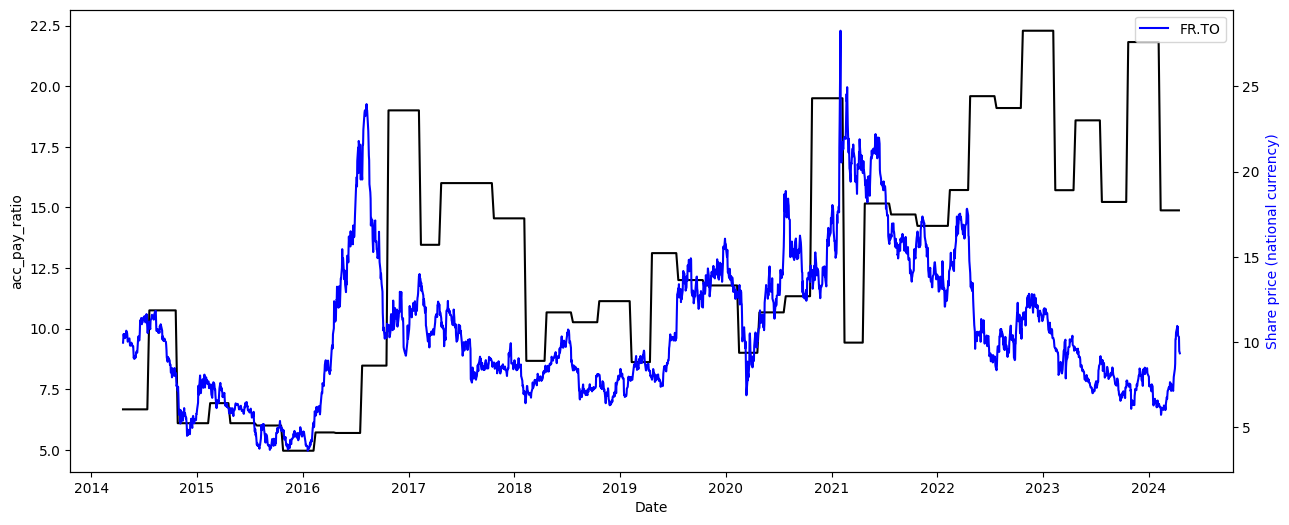

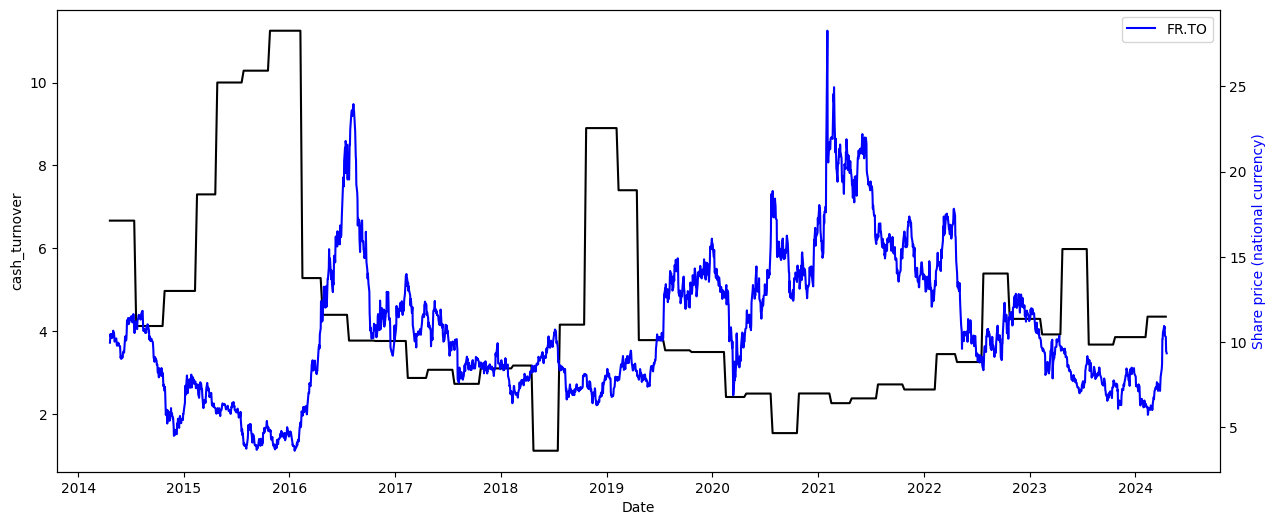

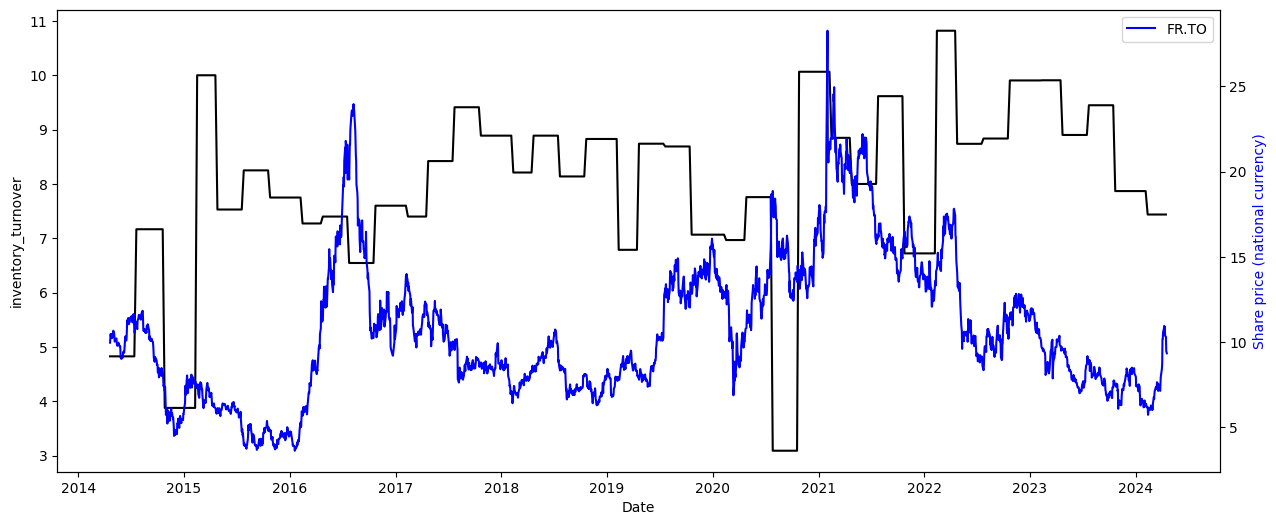

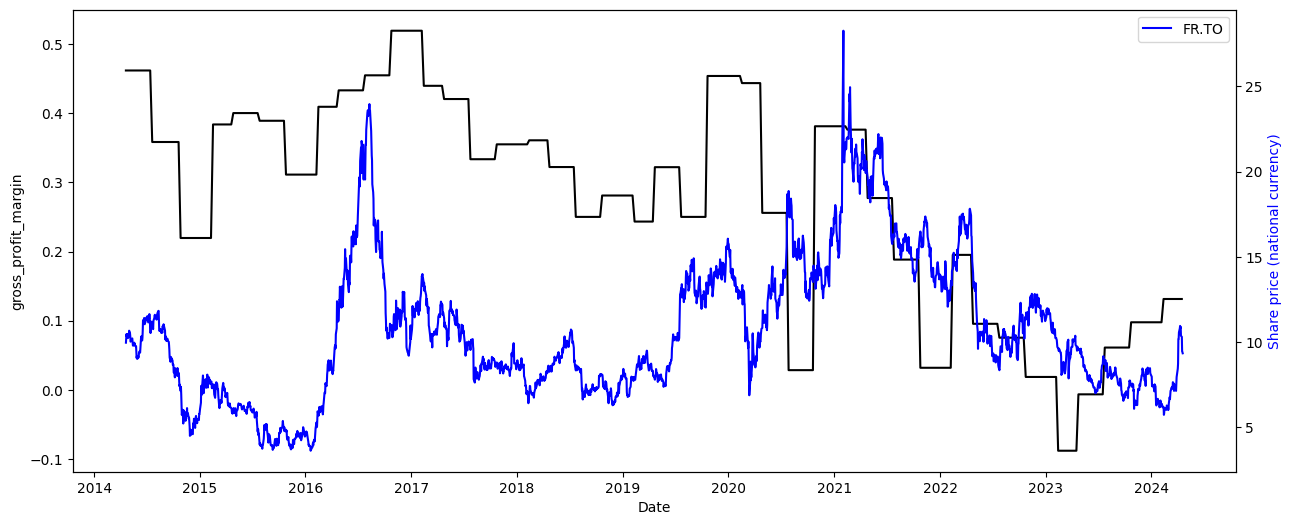

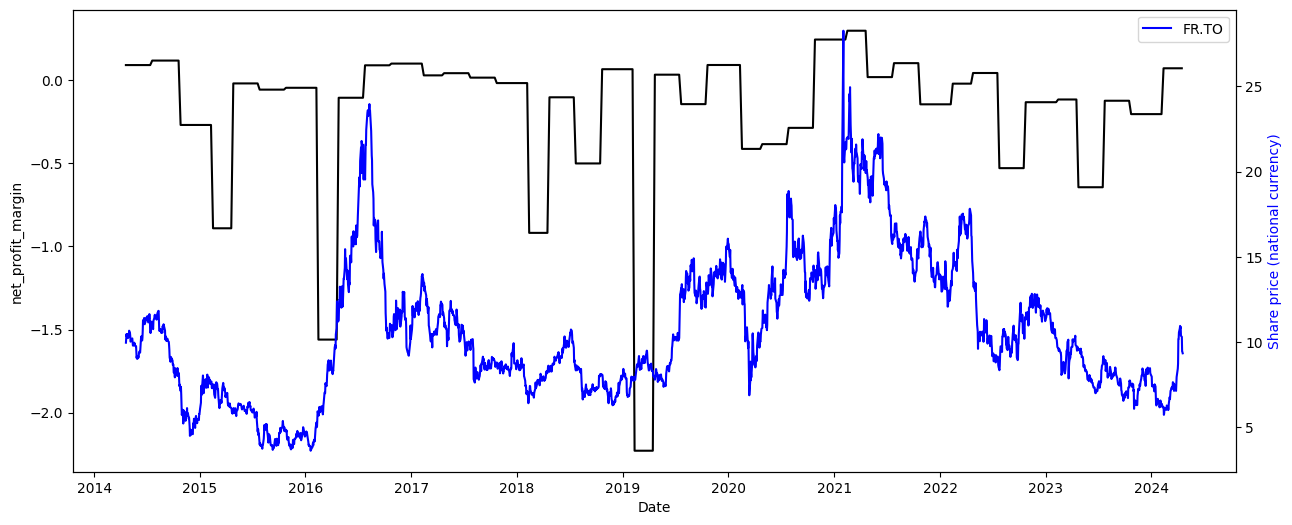

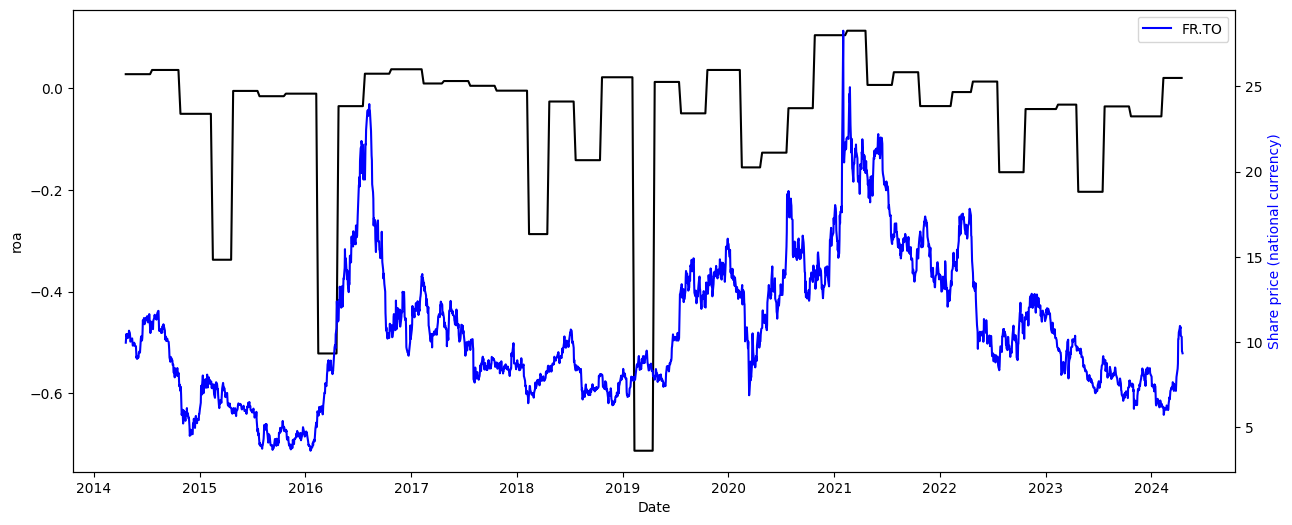

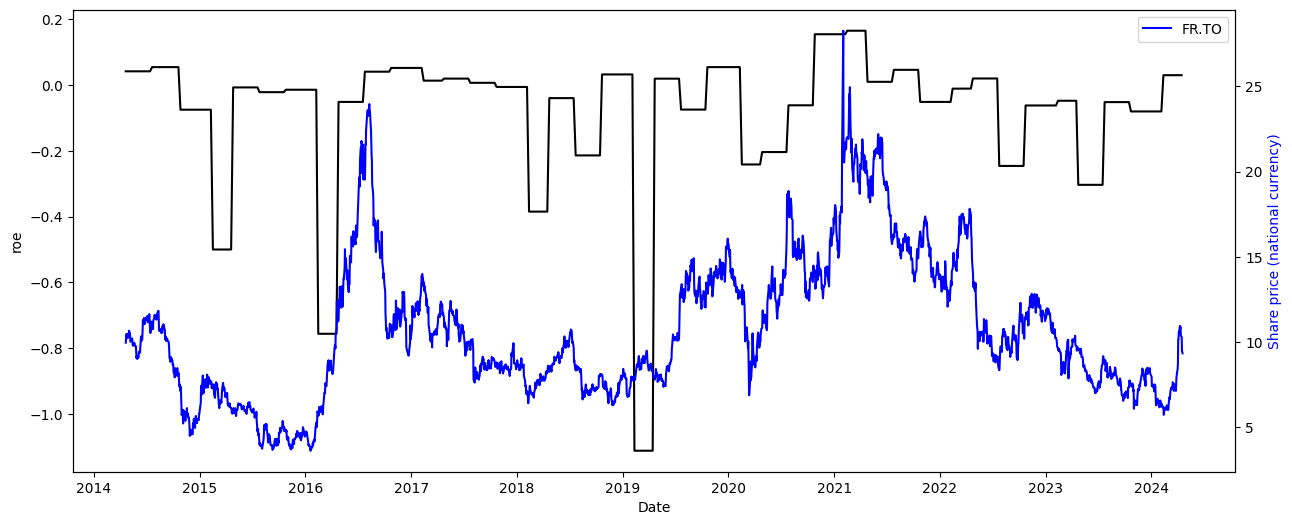

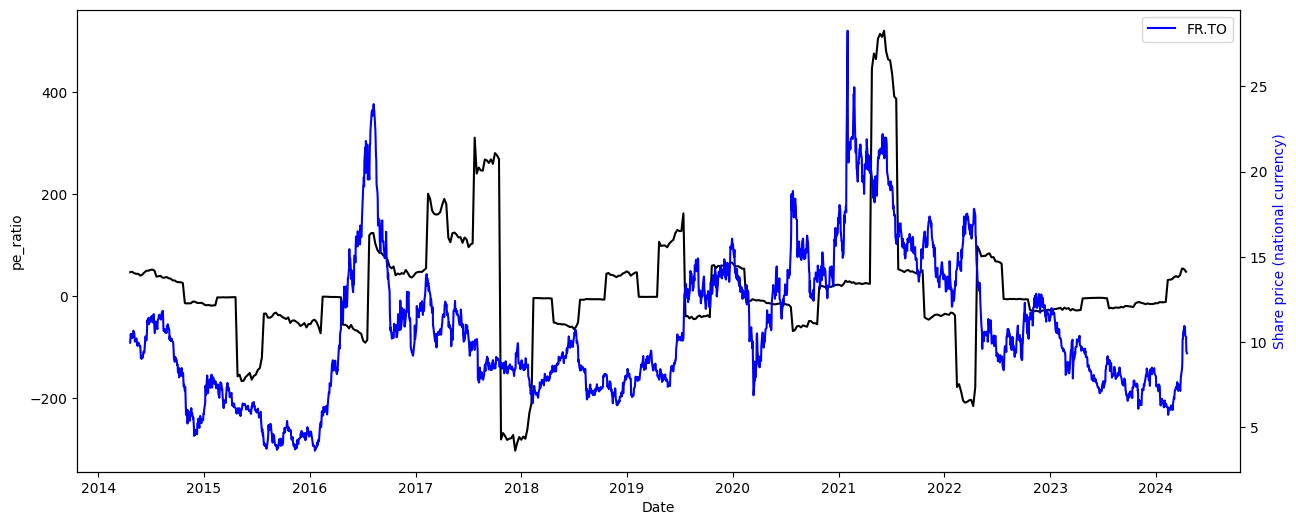

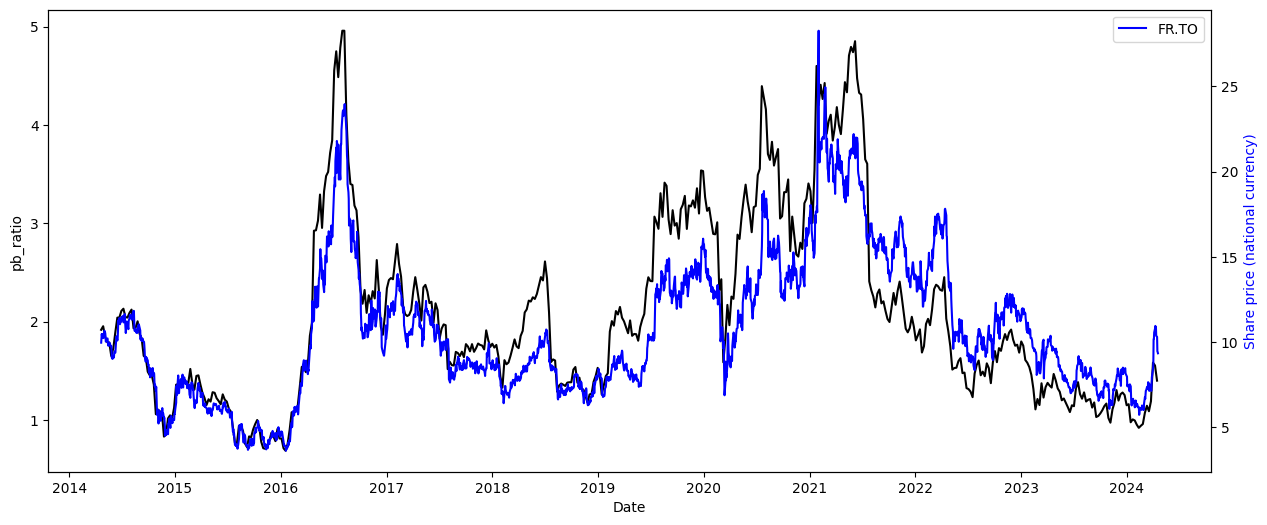

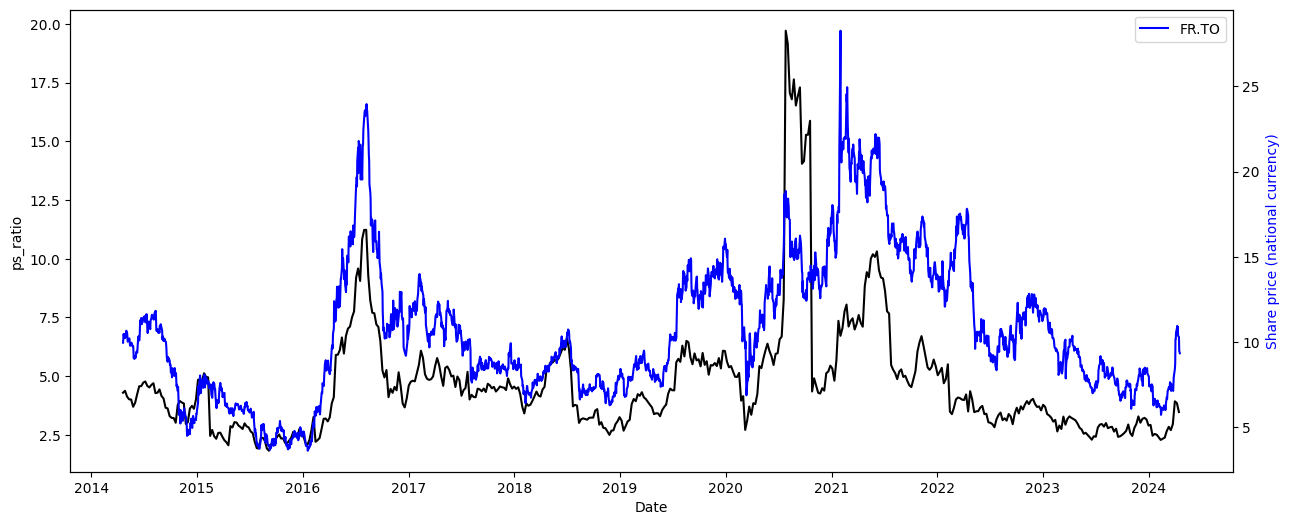

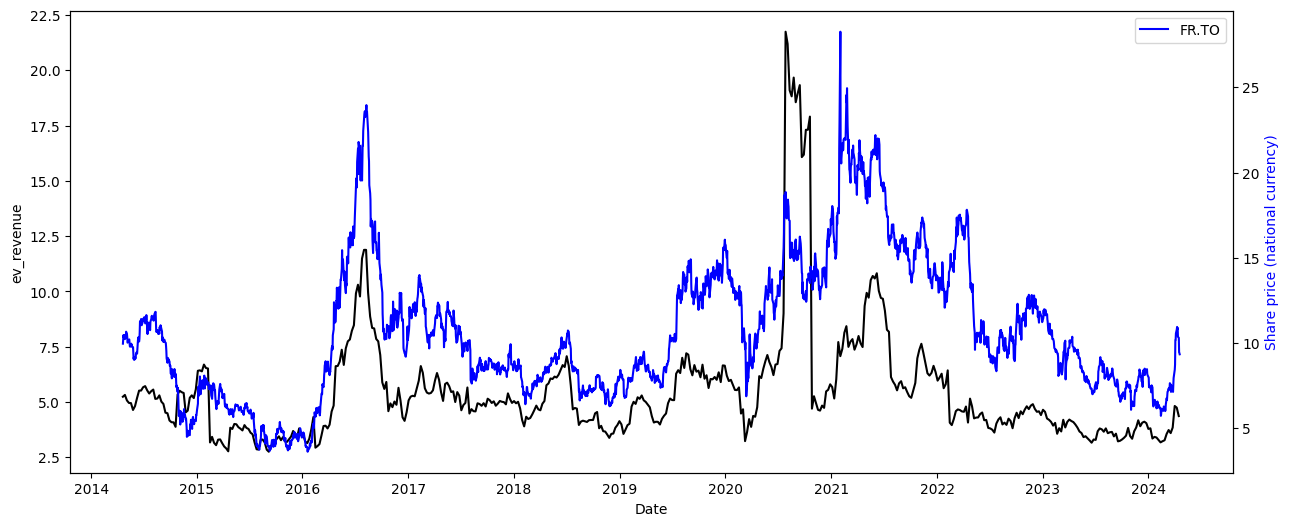

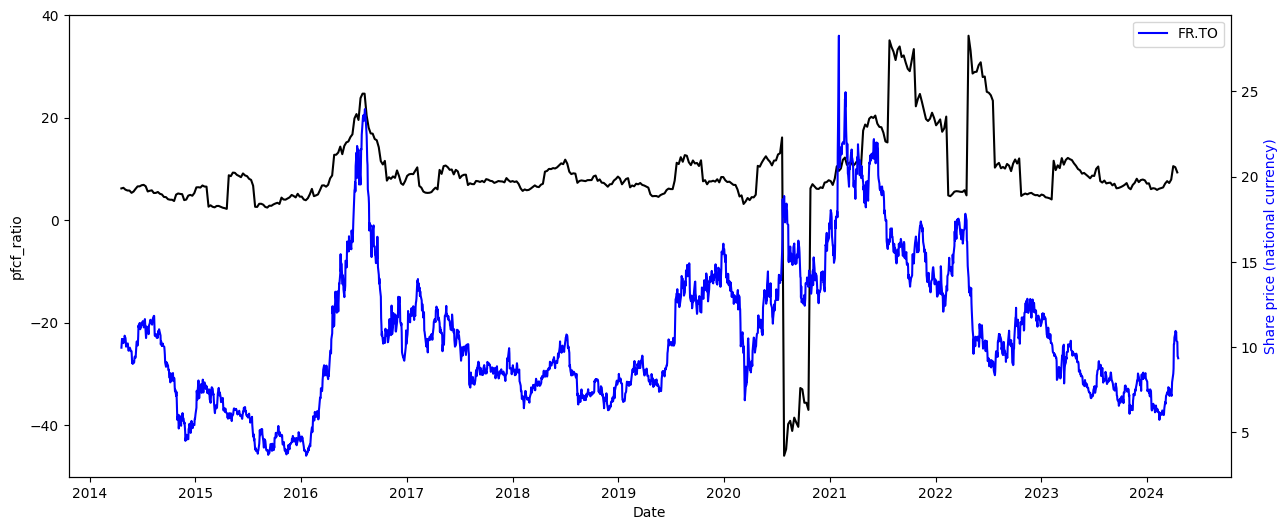

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

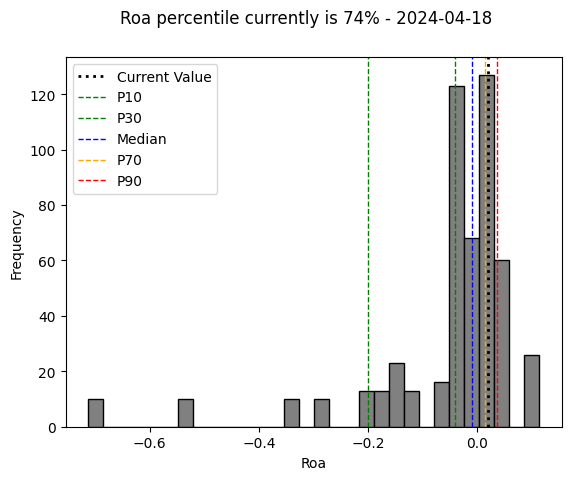

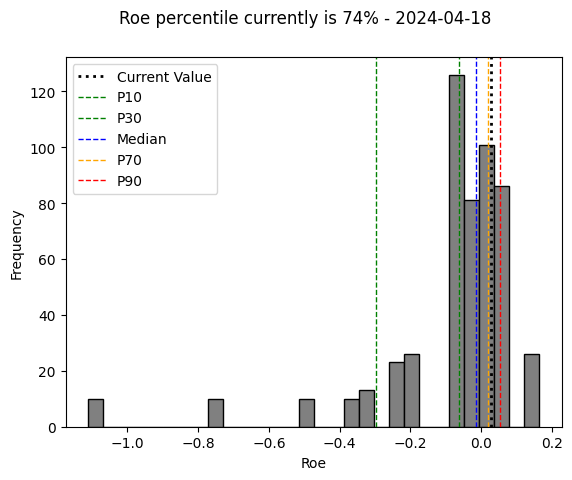

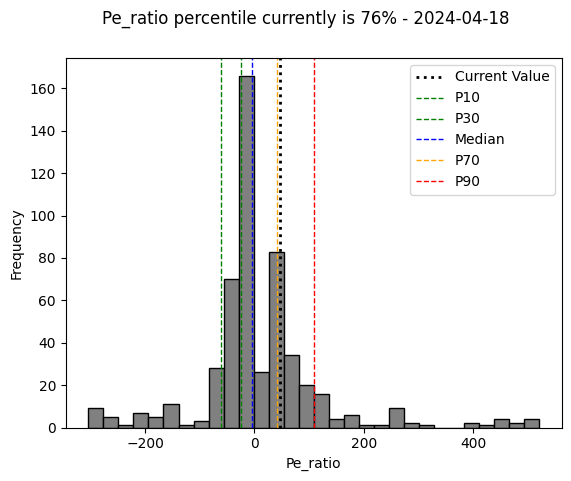

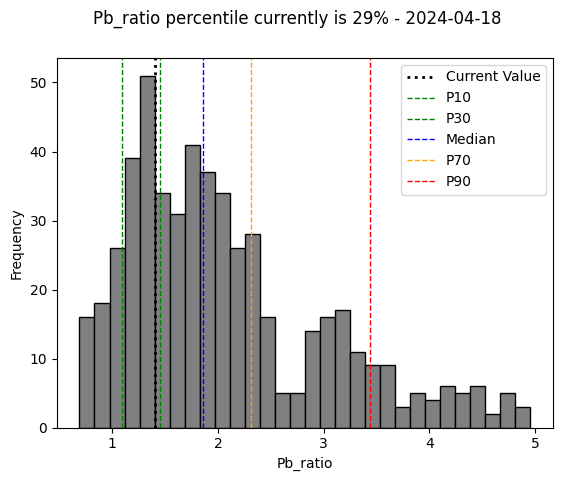

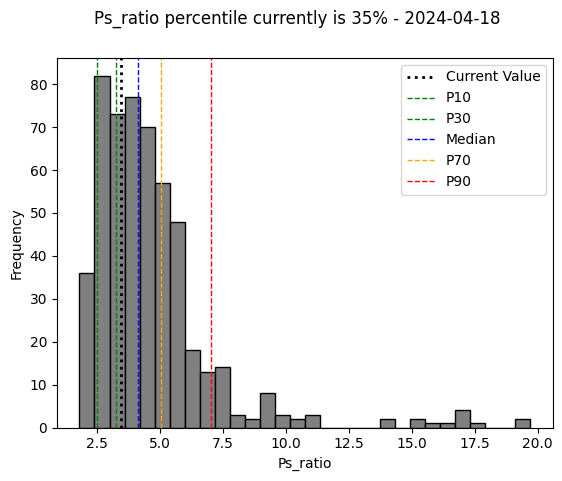

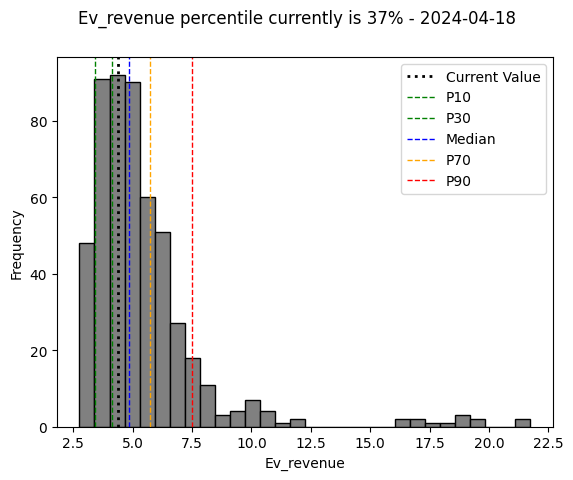

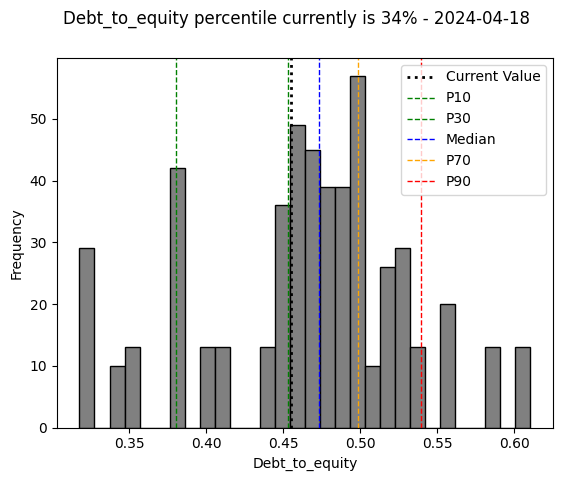

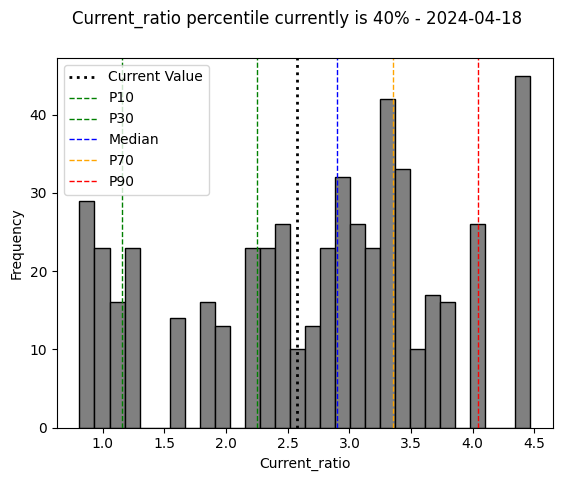

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.998951,0.123431,0.216699,0.173878,0.150229,-0.215539,0.247472
roe,0.998951,1.000000,0.121470,0.207177,0.167421,0.143513,-0.232410,0.239932
pe_ratio,0.123431,0.121470,1.000000,0.319447,0.184788,0.150653,-0.129411,0.286394
pb_ratio,0.216699,0.207177,0.319447,1.000000,0.789347,0.730504,0.197449,0.438342
ps_ratio,0.173878,0.167421,0.184788,0.789347,1.000000,0.993500,0.208521,0.248021
ev_revenue,0.150229,0.143513,0.150653,0.730504,0.993500,1.000000,0.247766,0.169432
debt_to_equity,-0.215539,-0.232410,-0.129411,0.197449,0.208521,0.247766,1.000000,-0.188098
current_ratio,0.247472,0.239932,0.286394,0.438342,0.248021,0.169432,-0.188098,1.000000


10 timestemos have been found!


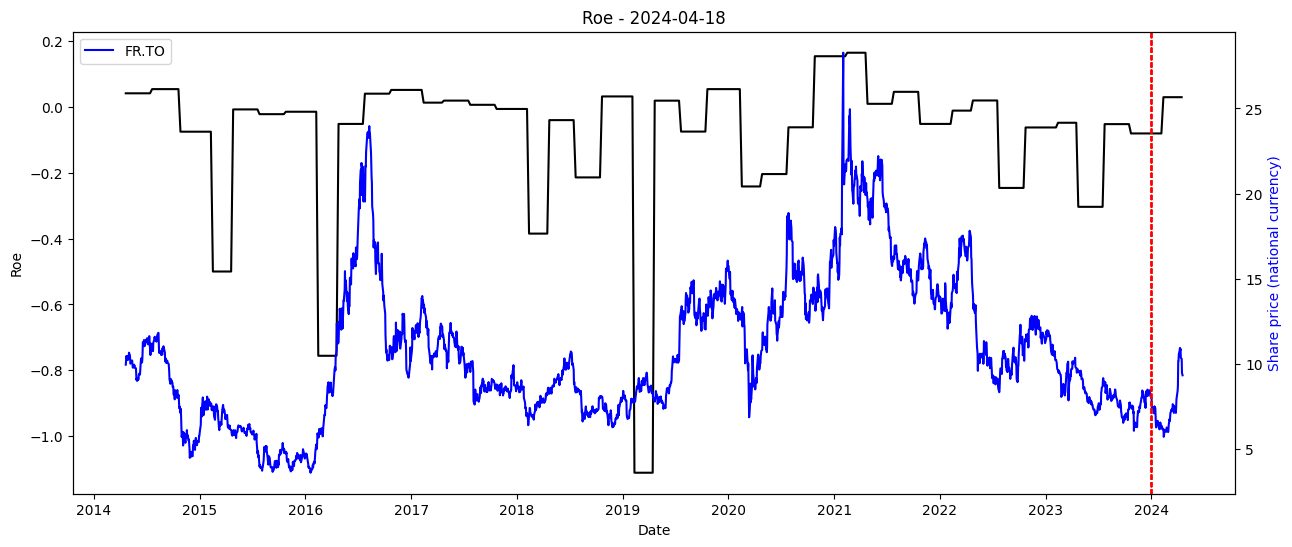

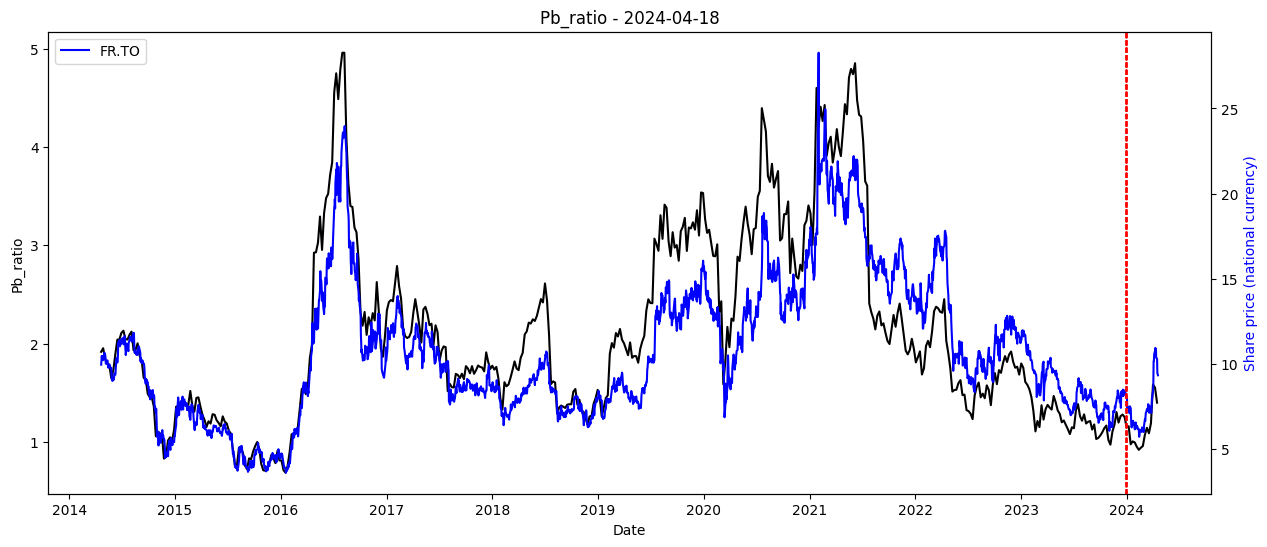

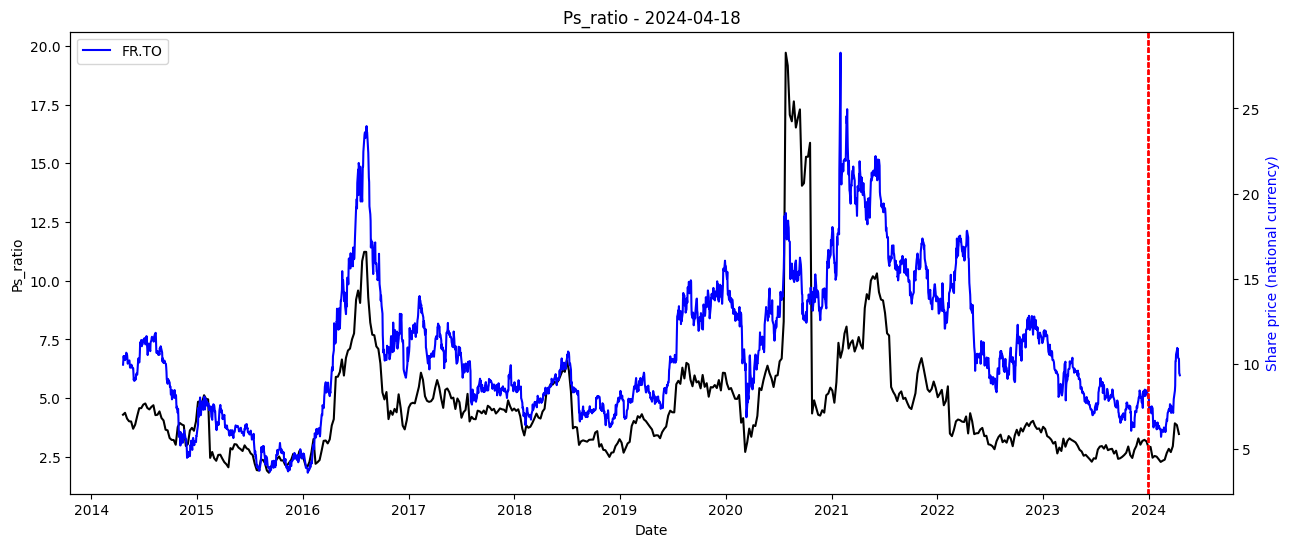

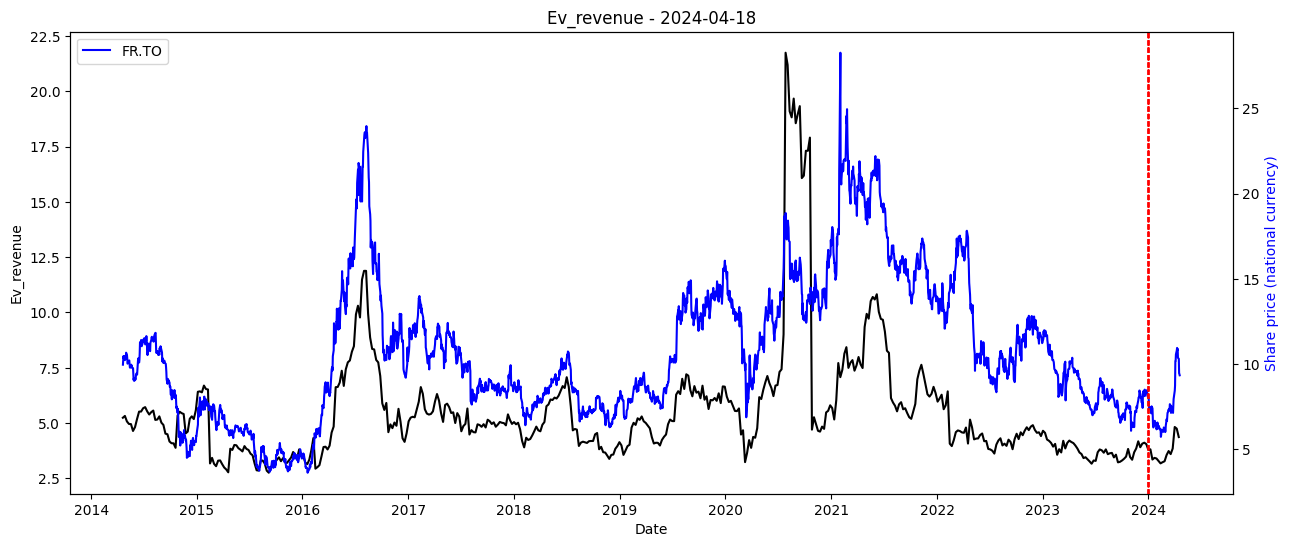

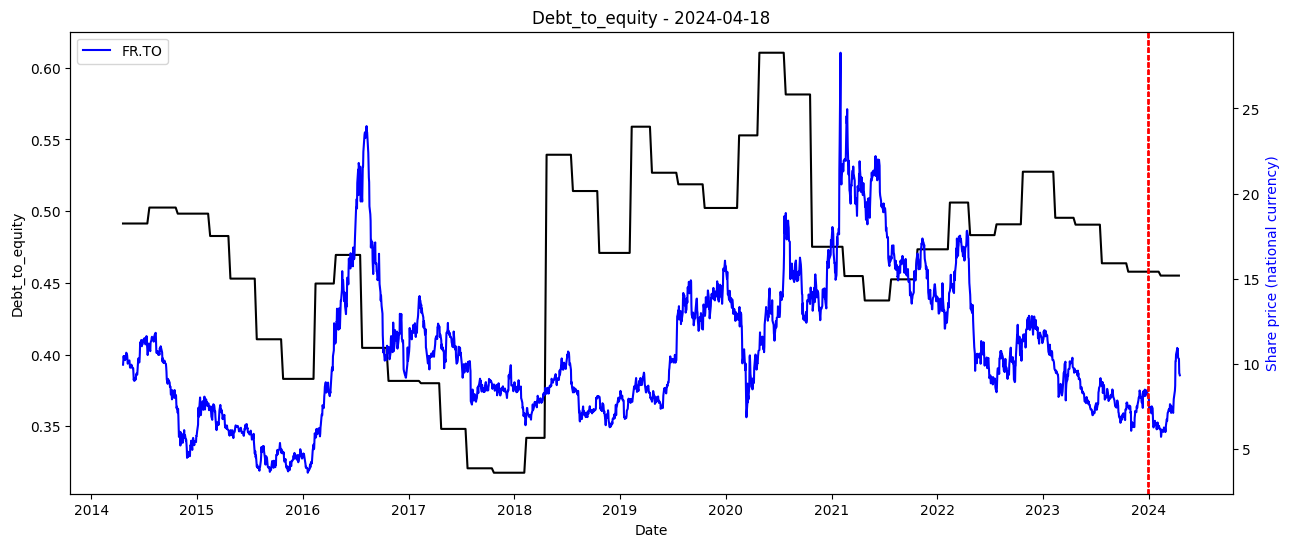

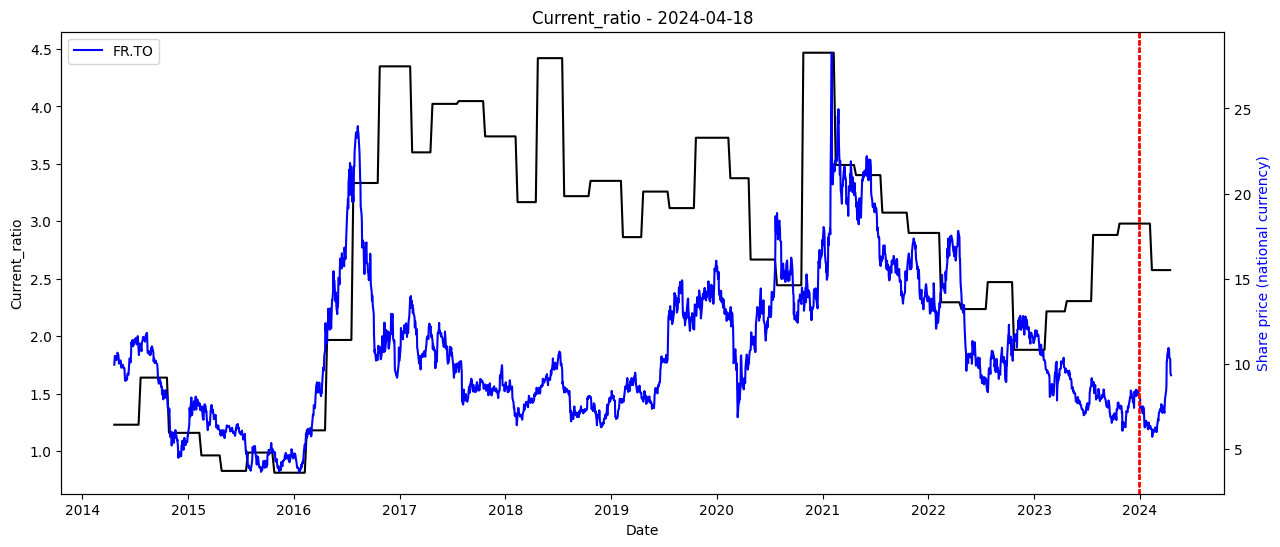

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )